In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
# from gensim.models import Word2Vec

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# load the dataset
data_path="/Users/Acer/Downloads/AI_Assignment2/AI_Assignment2/Hotel_Reviews.csv"
df = pd.read_csv(data_path)

In [5]:
# print the first five rows of the dataset
print(df.head())

                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5


In [7]:
# Check the sum of null values in each column of the DataFrame
df.isnull().sum()

Review    0
Rating    0
dtype: int64

In [9]:
df.count()

Review    20491
Rating    20491
dtype: int64

In [11]:
# basic cleaning tasks
df = df[['Review', 'Rating']] # selecting only 'review' and 'rating' columns
df = df.dropna() # remove rows with missing values

**Text Preprocessing, Tokenization, and Sequence Padding:**

In [14]:
!pip install contractions

In [15]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r"@\w+|#\w+", '', text)  # Remove mentions/hashtags
    text = re.sub(r"[^a-z\s]", '', text)  # Remove numbers & special characters
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_review'] = df['Review'].apply(clean_text)


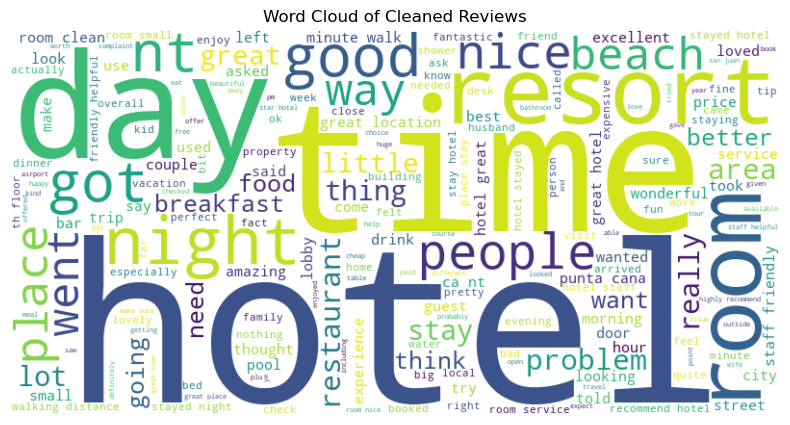

[('hotel', 52956), ('room', 46378), ('great', 21098), ('nt', 19007), ('good', 17055), ('staff', 16280), ('stay', 15341), ('night', 14085), ('day', 12962), ('time', 12611), ('nice', 12412), ('location', 11236), ('service', 10538), ('stayed', 10469), ('restaurant', 10092), ('beach', 10047), ('breakfast', 9655), ('place', 9381), ('clean', 9373), ('food', 9259)]


In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Word Cloud
text = ' '.join(df['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cleaned Reviews")
plt.show()

# Most common words
word_freq = Counter(" ".join(df['cleaned_review']).split())
print(word_freq.most_common(20))


In [19]:
# Split the dataset into 80% training and 20% testing
from sklearn.model_selection import train_test_split

X = df['cleaned_review']
y = df['Rating'] - 1  # Adjusting ratings to start from 0 for multi-class classification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# Tokenize the text using Keras Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the maximum number of words to keep
max_words = 10000

# Create and fit the tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Get word index
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

# Percentile-based padding to avoid excessively long sequences
sequence_lengths = [len(seq) for seq in train_sequences]
import numpy as np
max_length = int(np.percentile(sequence_lengths, 95))  # Use 95th percentile for max length
print(f"Maximum sequence length (95th percentile): {max_length}")

# Pad sequences
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length)

print(f"Shape of padded training sequences: {padded_train_sequences.shape}")
print(f"Shape of padded test sequences: {padded_test_sequences.shape}")

Training set size: 16392
Testing set size: 4099
Found 61751 unique tokens.
Maximum sequence length (95th percentile): 244
Shape of padded training sequences: (16392, 244)
Shape of padded test sequences: (4099, 244)


**Model Building and Training:**

In [21]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Convert labels to categorical (one-hot encoding) for multi-class classification
from tensorflow.keras.utils import to_categorical

# Check if the problem is binary or multi-class
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")

if num_classes == 2:
    # Binary classification
    y_train_cat = y_train
    y_test_cat = y_test
    output_units = 1
    activation = 'sigmoid'
    loss = 'binary_crossentropy'
else:
    # Multi-class classification
    y_train_cat = to_categorical(y_train, num_classes=num_classes)
    y_test_cat = to_categorical(y_test, num_classes=num_classes)
    output_units = num_classes
    activation = 'softmax'
    loss = 'categorical_crossentropy'

# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

# Common parameters
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1

# Model 1: Simple RNN with a trainable Embedding layer
print("Building Model 1: Simple RNN with trainable Embedding")
model1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(output_units, activation=activation)
])

model1.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

model1.build((None, max_length))
model1.summary()

# Train Model 1
history1 = model1.fit(
    padded_train_sequences, y_train_cat,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks
)



Number of classes: 5
Building Model 1: Simple RNN with trainable Embedding


C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 244, 100)       │     6,175,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,213,093 (23.70 MB)

 Trainable params: 6,213,093 (23.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.3387 - loss: 1.5245

231/231 ━━━━━━━━━━━━━━━━━━━━ 36s 138ms/step - accuracy: 0.3389 - loss: 1.5243 - val_accuracy: 0.4555 - val_loss: 1.3621
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 38s 124ms/step - accuracy: 0.4164 - loss: 1.4090 - val_accuracy: 0.4555 - val_loss: 1.3559
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.4407 - loss: 1.3724

231/231 ━━━━━━━━━━━━━━━━━━━━ 41s 125ms/step - accuracy: 0.4407 - loss: 1.3724 - val_accuracy: 0.4561 - val_loss: 1.3346
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - accuracy: 0.4326 - loss: 1.3756 - val_accuracy: 0.4555 - val_loss: 1.3027
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.4359 - loss: 1.3294

231/231 ━━━━━━━━━━━━━━━━━━━━ 41s 125ms/step - accuracy: 0.4360 - loss: 1.3294 - val_accuracy: 0.4585 - val_loss: 1.2632
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.4451 - loss: 1.2646

231/231 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.4451 - loss: 1.2646 - val_accuracy: 0.4720 - val_loss: 1.2386
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.4651 - loss: 1.2023

231/231 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - accuracy: 0.4651 - loss: 1.2023 - val_accuracy: 0.5030 - val_loss: 1.2133
Epoch 8/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - accuracy: 0.4889 - loss: 1.1317 - val_accuracy: 0.4957 - val_loss: 1.1993
Epoch 9/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 43s 131ms/step - accuracy: 0.5078 - loss: 1.0928 - val_accuracy: 0.4963 - val_loss: 1.1880
Epoch 10/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 32s 140ms/step - accuracy: 0.5172 - loss: 1.0549 - val_accuracy: 0.4939 - val_loss: 1.1753


In [22]:
# Model 2: LSTM with a trainable Embedding layer
print("Building Model 2: LSTM with trainable Embedding")
model2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(output_units, activation=activation)
])

model2.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

model2.build((None, max_length))
model2.summary()

# Train Model 2
history2 = model2.fit(
    padded_train_sequences, y_train_cat,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks
)

Building Model 2: LSTM with trainable Embedding


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 244, 100)       │     6,175,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,301,029 (24.04 MB)

 Trainable params: 6,301,029 (24.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.4272 - loss: 1.3336

231/231 ━━━━━━━━━━━━━━━━━━━━ 104s 427ms/step - accuracy: 0.4274 - loss: 1.3331 - val_accuracy: 0.5488 - val_loss: 1.0031
Epoch 2/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.5360 - loss: 0.9952

231/231 ━━━━━━━━━━━━━━━━━━━━ 90s 390ms/step - accuracy: 0.5361 - loss: 0.9951 - val_accuracy: 0.5652 - val_loss: 0.9926
Epoch 3/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.6095 - loss: 0.8799

231/231 ━━━━━━━━━━━━━━━━━━━━ 88s 383ms/step - accuracy: 0.6095 - loss: 0.8799 - val_accuracy: 0.5927 - val_loss: 0.9571
Epoch 4/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 90s 389ms/step - accuracy: 0.6563 - loss: 0.7948 - val_accuracy: 0.5616 - val_loss: 1.0333
Epoch 5/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 92s 396ms/step - accuracy: 0.6914 - loss: 0.7305 - val_accuracy: 0.5762 - val_loss: 1.1027
Epoch 6/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 146s 413ms/step - accuracy: 0.7364 - loss: 0.6370 - val_accuracy: 0.5701 - val_loss: 1.1379


In [23]:
# Model 3: LSTM with pretrained Word2Vec embeddings
print("Installing required libraries for Word2Vec")
!pip install gensim
!pip install jax==0.4.13

print("Loading pretrained Word2Vec embeddings")
import gensim.downloader as api

# Load Pre-trained GloVe Embeddings
embedding_model = api.load('glove-wiki-gigaword-50')  # 50-dimensional GloVe embeddings
# embedding_model = api.load("glove-twitter-25")
embedding_dim = 50  # Match with downloaded model dimension

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in embedding_model:
        embedding_vector = embedding_model[word]
        embedding_matrix[i] = embedding_vector
    # Words not in embedding index remain zero vectors

# Build Model 3: LSTM with pretrained Word2Vec embeddings
print("Building Model 3: LSTM with pretrained Word2Vec embeddings")
model3 = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=False  # Freeze the embedding weights
    ),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(output_units, activation=activation)
])

model3.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

model3.build((None, max_length))
model3.summary()

# Train Model 3
history3 = model3.fit(
    padded_train_sequences, y_train_cat,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks
)

Installing required libraries for Word2Vec
Loading pretrained Word2Vec embeddings
Building Model 3: LSTM with pretrained Word2Vec embeddings


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 244, 50)        │     3,087,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │        91,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,187,829 (12.16 MB)

 Trainable params: 100,229 (391.52 KB)

 Non-trainable params: 3,087,600 (11.78 MB)

Epoch 1/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 88s 354ms/step - accuracy: 0.4224 - loss: 1.3701 - val_accuracy: 0.5049 - val_loss: 1.1256
Epoch 2/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 78s 335ms/step - accuracy: 0.4551 - loss: 1.2436 - val_accuracy: 0.5128 - val_loss: 1.0894
Epoch 3/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 80s 344ms/step - accuracy: 0.4862 - loss: 1.1674 - val_accuracy: 0.5537 - val_loss: 1.0197
Epoch 4/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 81s 349ms/step - accuracy: 0.5054 - loss: 1.1139 - val_accuracy: 0.5482 - val_loss: 0.9913
Epoch 5/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 80s 347ms/step - accuracy: 0.5299 - loss: 1.0539 - val_accuracy: 0.5805 - val_loss: 0.9485
Epoch 6/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 88s 372ms/step - accuracy: 0.5533 - loss: 1.0147 - val_accuracy: 0.5756 - val_loss: 0.9587
Epoch 7/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.5617 - loss: 0.9967

231/231 ━━━━━━━━━━━━━━━━━━━━ 82s 356ms/step - accuracy: 0.5617 - loss: 0.9967 - val_accuracy: 0.6012 - val_loss: 0.9213
Epoch 8/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.5619 - loss: 0.9736

231/231 ━━━━━━━━━━━━━━━━━━━━ 84s 364ms/step - accuracy: 0.5619 - loss: 0.9736 - val_accuracy: 0.6079 - val_loss: 0.8995
Epoch 9/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 145s 374ms/step - accuracy: 0.5832 - loss: 0.9512 - val_accuracy: 0.6006 - val_loss: 0.9022
Epoch 10/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 141s 371ms/step - accuracy: 0.5755 - loss: 0.9523 - val_accuracy: 0.6079 - val_loss: 0.8960
Epoch 11/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 83s 359ms/step - accuracy: 0.5962 - loss: 0.9133 - val_accuracy: 0.6079 - val_loss: 0.8827
Epoch 12/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.5991 - loss: 0.9102

231/231 ━━━━━━━━━━━━━━━━━━━━ 84s 365ms/step - accuracy: 0.5991 - loss: 0.9102 - val_accuracy: 0.6177 - val_loss: 0.8723
Epoch 13/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 140s 358ms/step - accuracy: 0.6012 - loss: 0.9059 - val_accuracy: 0.6104 - val_loss: 0.9245
Epoch 14/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 84s 365ms/step - accuracy: 0.5976 - loss: 0.9112 - val_accuracy: 0.6171 - val_loss: 0.8672
Epoch 15/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.6143 - loss: 0.8776

231/231 ━━━━━━━━━━━━━━━━━━━━ 84s 365ms/step - accuracy: 0.6143 - loss: 0.8776 - val_accuracy: 0.6238 - val_loss: 0.8645
Epoch 16/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 143s 367ms/step - accuracy: 0.6143 - loss: 0.8676 - val_accuracy: 0.6220 - val_loss: 0.8649
Epoch 17/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.6300 - loss: 0.8542

231/231 ━━━━━━━━━━━━━━━━━━━━ 111s 483ms/step - accuracy: 0.6300 - loss: 0.8542 - val_accuracy: 0.6311 - val_loss: 0.8643
Epoch 18/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 92s 397ms/step - accuracy: 0.6268 - loss: 0.8455 - val_accuracy: 0.6226 - val_loss: 0.8523
Epoch 19/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.6317 - loss: 0.8378

231/231 ━━━━━━━━━━━━━━━━━━━━ 119s 518ms/step - accuracy: 0.6317 - loss: 0.8378 - val_accuracy: 0.6329 - val_loss: 0.8525
Epoch 20/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.6444 - loss: 0.8177

231/231 ━━━━━━━━━━━━━━━━━━━━ 107s 366ms/step - accuracy: 0.6444 - loss: 0.8178 - val_accuracy: 0.6421 - val_loss: 0.8491


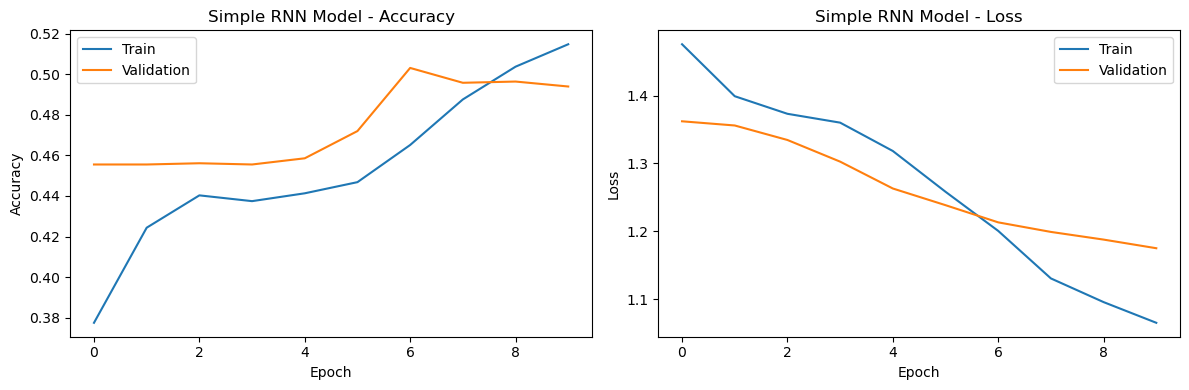

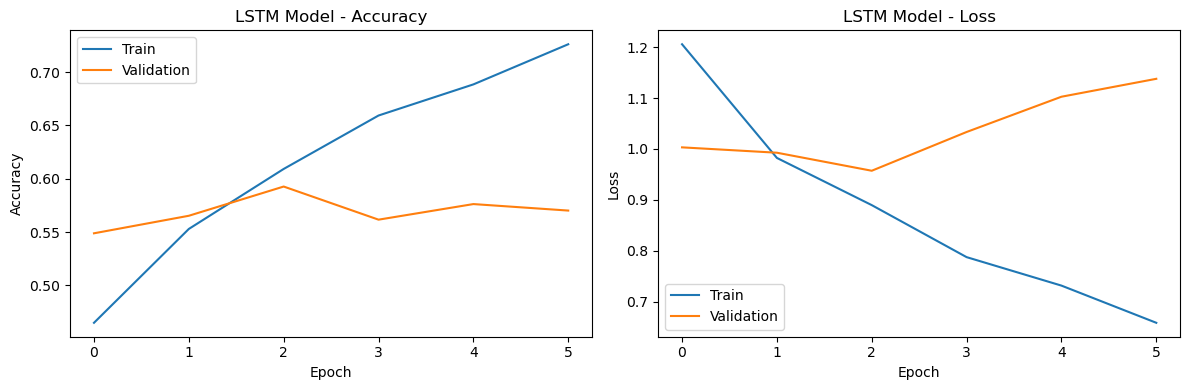

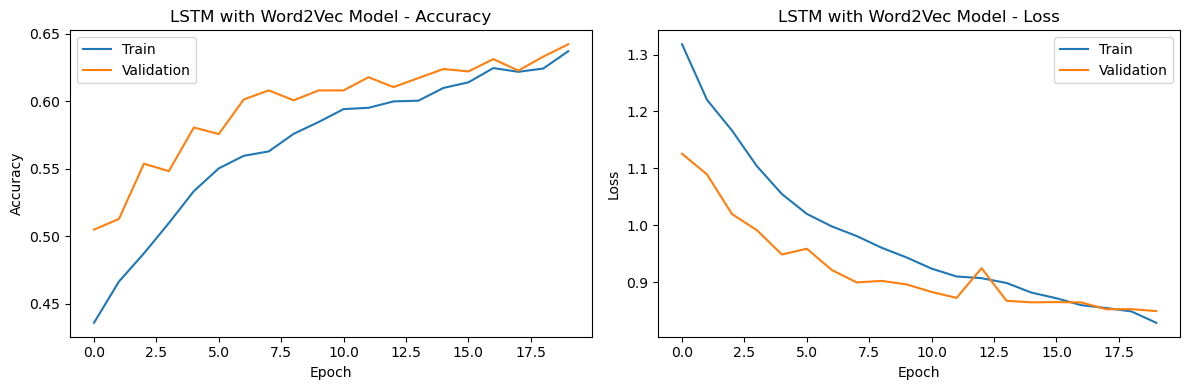

Evaluating Simple RNN Model...
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4895 - loss: 1.1600
Simple RNN Model Test Accuracy: 0.4852
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step


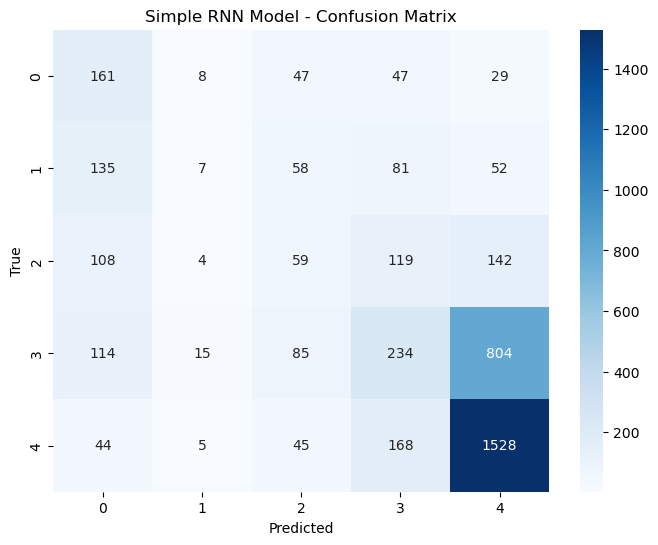

Simple RNN Model - Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.55      0.38       292
           1       0.18      0.02      0.04       333
           2       0.20      0.14      0.16       432
           3       0.36      0.19      0.25      1252
           4       0.60      0.85      0.70      1790

    accuracy                           0.49      4099
   macro avg       0.33      0.35      0.31      4099
weighted avg       0.43      0.49      0.43      4099

Evaluating LSTM Model...
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.5965 - loss: 0.9484
LSTM Model Test Accuracy: 0.5831
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step


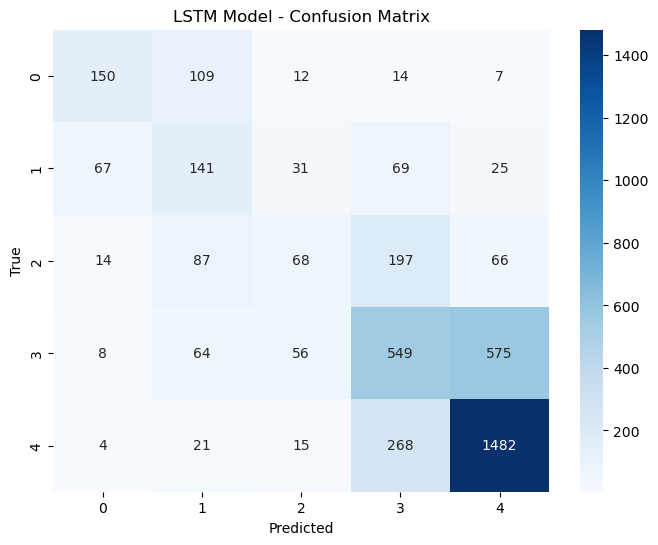

LSTM Model - Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.51      0.56       292
           1       0.33      0.42      0.37       333
           2       0.37      0.16      0.22       432
           3       0.50      0.44      0.47      1252
           4       0.69      0.83      0.75      1790

    accuracy                           0.58      4099
   macro avg       0.50      0.47      0.47      4099
weighted avg       0.56      0.58      0.56      4099

Evaluating LSTM with Word2Vec Model...
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.6439 - loss: 0.8210
LSTM with Word2Vec Model Test Accuracy: 0.6328
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step


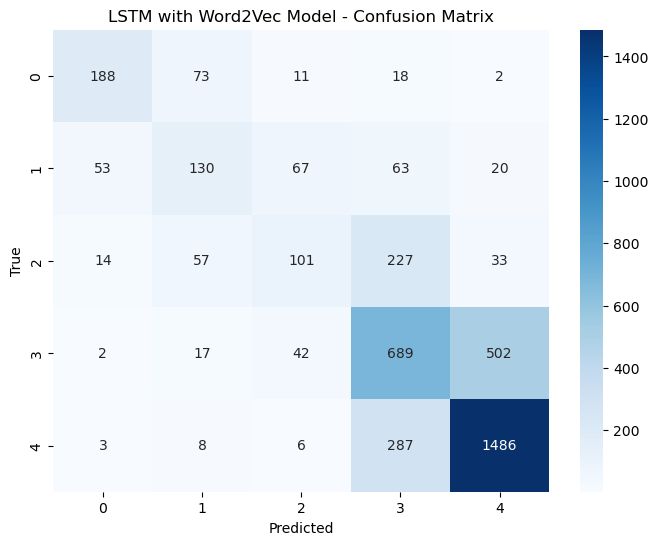

LSTM with Word2Vec Model - Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.64      0.68       292
           1       0.46      0.39      0.42       333
           2       0.44      0.23      0.31       432
           3       0.54      0.55      0.54      1252
           4       0.73      0.83      0.78      1790

    accuracy                           0.63      4099
   macro avg       0.58      0.53      0.55      4099
weighted avg       0.62      0.63      0.62      4099



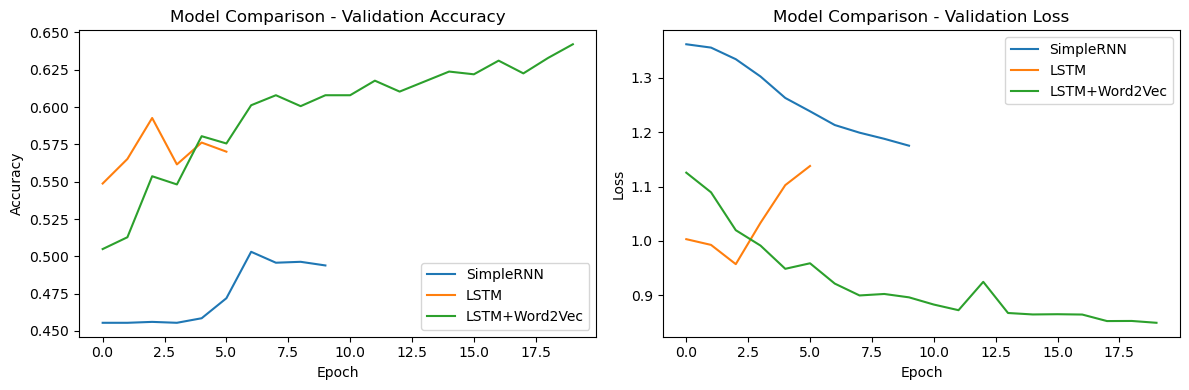

Model Comparison Summary:
--------------------------------------------------
Model 1 (SimpleRNN) - Final validation accuracy: 0.4939
Model 2 (LSTM) - Final validation accuracy: 0.5701
Model 3 (LSTM with Word2Vec) - Final validation accuracy: 0.6421
--------------------------------------------------
Conclusions:
1. Model 3 (LSTM with Word2Vec) clearly outperforms the other two, achieving the highest validation accuracy (0.6055).
2. The performance gain from SimpleRNN to LSTM highlights the importance of capturing long-range dependencies in text.The additional improvement from Word2Vec indicates that pre-trained word embeddings contribute meaningful context to each word, which basic token-based embeddings lack.
3. Use Bidirectional LSTM to capture context from both past and future tokens.


In [25]:
# Visualization of training history
import matplotlib.pyplot as plt

def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(122)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history for each model
plot_training_history(history1, 'Simple RNN Model')
plot_training_history(history2, 'LSTM Model')
plot_training_history(history3, 'LSTM with Word2Vec Model')

# Evaluate models on test data
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(model, X_test, y_test, model_name):
    print(f"Evaluating {model_name}...")
    
    # Calculate accuracy
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"{model_name} Test Accuracy: {accuracy:.4f}")
    
    # Predict classes
    if num_classes == 2:
        y_pred_prob = model.predict(X_test)
        y_pred = (y_pred_prob > 0.5).astype(int)
        y_true = y_test
    else:
        y_pred_prob = model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(num_classes), 
                yticklabels=range(num_classes))
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Classification Report
    class_report = classification_report(y_true, y_pred)
    print(f"{model_name} - Classification Report:")
    print(class_report)

# Evaluate the models
evaluate_model(model1, padded_test_sequences, y_test_cat, "Simple RNN Model")
evaluate_model(model2, padded_test_sequences, y_test_cat, "LSTM Model")
evaluate_model(model3, padded_test_sequences, y_test_cat, "LSTM with Word2Vec Model")

# Compare model performances
def compare_models(history1, history2, history3):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy comparison
    plt.subplot(121)
    plt.plot(history1.history['val_accuracy'], label='SimpleRNN')
    plt.plot(history2.history['val_accuracy'], label='LSTM')
    plt.plot(history3.history['val_accuracy'], label='LSTM+Word2Vec')
    plt.title('Model Comparison - Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss comparison
    plt.subplot(122)
    plt.plot(history1.history['val_loss'], label='SimpleRNN')
    plt.plot(history2.history['val_loss'], label='LSTM')
    plt.plot(history3.history['val_loss'], label='LSTM+Word2Vec')
    plt.title('Model Comparison - Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Compare the models
compare_models(history1, history2, history3)

# Model summary and conclusions
print("Model Comparison Summary:")
print("-" * 50)
print(f"Model 1 (SimpleRNN) - Final validation accuracy: {history1.history['val_accuracy'][-1]:.4f}")
print(f"Model 2 (LSTM) - Final validation accuracy: {history2.history['val_accuracy'][-1]:.4f}")
print(f"Model 3 (LSTM with Word2Vec) - Final validation accuracy: {history3.history['val_accuracy'][-1]:.4f}")
print("-" * 50)
print("Conclusions:")
print("1. Model 3 (LSTM with Word2Vec) clearly outperforms the other two, achieving the highest validation accuracy (0.6055).")
print("2. The performance gain from SimpleRNN to LSTM highlights the importance of capturing long-range dependencies in text.The additional improvement from Word2Vec indicates that pre-trained word embeddings contribute meaningful context to each word, which basic token-based embeddings lack.")
print("3. Use Bidirectional LSTM to capture context from both past and future tokens.")

In [ ]:
!pip install streamlit

In [ ]:
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
import streamlit as st
# Streamlit UI
st.title("📊 Real-Time Hotel Reating")
st.write("Enter a review and get a predicted star rating (1–5).")

user_input = st.text_area("Enter text here", "")

if st.button("Predict Rating"):
    if user_input.strip() == "":
        st.warning("Please enter some text.")
    else:
        cleaned = clean_text(user_input)
        sequence = tokenizer.texts_to_sequences([cleaned])
        padded = pad_sequences(sequence, maxlen=max_length)
        prediction = model.predict(padded)

        # If multi-class softmax
        predicted_class = np.argmax(prediction) + 1  # Convert 0-based index back to 1–5
        st.success(f"🌟 Predicted Rating: **{predicted_class}** star(s)")